In [96]:
import os
import openai
import json
import pandas as pd

In [101]:
# try to load the api key from file
secrets_filename = os.path.join(os.path.abspath(
    # replace values here if this was cloned
    os.path.dirname('deser.ipynb')), 'secret2.txt')
try:
    with open(secrets_filename, 'r') as f:
        api_key = f.read().strip()
        openai.api_key = api_key
except Exception as e:
    print(e)


In [102]:
def get_entity_list(entity: str, features, type_of=type(list), n=5):
    artifacts = ['...',r'\n']
    if type(type_of) != type(list()):
        pass
        # print('type other than list passed')
    # delimiter = "|"

    if type(type_of) != type(dict()):
        clean_format_name = '.json file'
    else:
        clean_format_name = 'Python List'
        
    role_context = """You are a system that processes data. 
    You make assumptions instead of asking for clarification. 
    Create values for the following entity. Your result should 
    contain no explanation or comments. Your result should be 
    valid json that can be serialized"""

    prompt = f"""
    Create an list of values based on a prompt.
    Limit your result to {n} records of data. 
    The parent json should have only one field: data. 
    The data field contains a list of values.
    Do not ask for clarification. Make inferences. 
    If a record will be cut off, do not include it in the output.
    # Format your results as {clean_format_name}.
    No comments in the code.
    """
    prompt += r' Use this example {"data":[{"name":"item1","weight":2},{"name":"item2","weight":1}]}'

    # add specific entity and features 
    prompt += f" for entity=\"{entity}\""
    feature_str = ', '.join(features)
    prompt += f" having features=\"{entity}, {feature_str}\""

    # only the messages have been changed
    res = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "system", "content": role_context},
                  {"role": "user", "content": prompt}
                  ],
        temperature=0.8,
        max_tokens=1024,
        n=1,
        stop=None,
        timeout=30,
        presence_penalty=0.5,
        frequency_penalty=0.5
    )

    # select choices from the response
    choices = res['choices']
    if len(choices) != 1:
        print('')
    for choice in choices:
        res_ser = choice['message']['content']
        # return lists
        if type_of == type(list()):
            res_list = res_ser.split('|')
            return res_list[:n]
        else:
            # remove chat's text artifacts before deserializing
            for artifact in artifacts:
                res_ser = res_ser.replace(artifact, '')
            data = json.loads(res_ser)['data']
            # return as a pd data frame
            return pd.DataFrame(data)


In [103]:
def entity_scatter_plot(entity, features, n=5):
    entity = entity.replace(" ", "_")
    features = [feature.replace(" ", "_") for feature in features]
    entity_list = get_entity_list(entity=entity, features=features, type_of=type(dict), n=5)

    df = pd.DataFrame(entity_list)

    x_vals = features[0]
    y_vals = features[1]

    # check types and change behavior accordingly
    for t in df.dtypes:
        pass
        # print(t)

    # create a scatter plot for the x and y features
    ax = df.plot.scatter(x=x_vals, y=y_vals)

    # add data labels
    for i, txt in enumerate(df[entity]):
        ax.annotate(txt, (df[x_vals][i], df[y_vals][i]))

    return df


  stl cardinals player  career_hr  career games played
1        Albert Pujols        656                 2818
0         Mark McGwire        583                 1874
2          Stan Musial        475                 3026
3          Ozzie Smith         28                 2573
4           Bob Gibson         24                  528


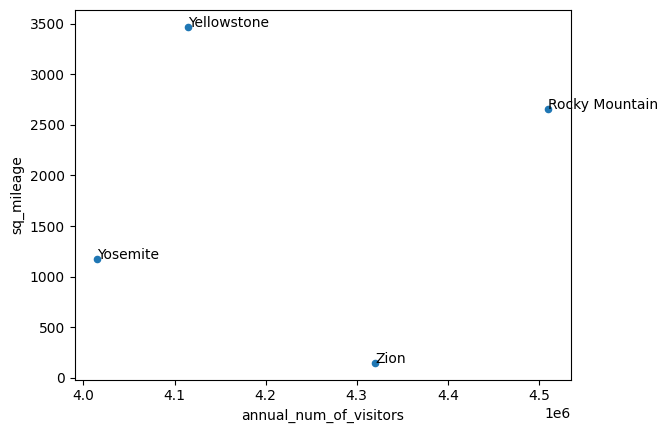

In [108]:
tries_ctr = 0
max_tries = 3
while tries_ctr < max_tries:
    try:
        print(get_entity_list(
            entity="stl cardinals player", 
            features=["career_hr", "career games played"]
        ).sort_values('career_hr', ascending=False))

        entity_scatter_plot(
            entity="us national parks", 
            features=["annual num of visitors", "sq mileage"]
        )
        break
    except Exception as e:
        print(e)
        continue
        